DL_MRI_reconstruction_baselines

# CODE TO TEST THE EVALUATE FUNCTIONS

## load imports + functions

In [1]:
import os
import argparse
import pathlib
from argparse import ArgumentParser
from typing import Optional

import h5py
import numpy as np
from runstats import Statistics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from fastmri.data import transforms

import torch
from torchvision.models import vgg19
from torchvision.transforms import Compose, ToTensor, Normalize, CenterCrop, Lambda

def determine_and_apply_mask_TARGET(target, recons, tgt_file=None):
    mask = (target != 0)
    gt = np.where(mask, target, 0)
    pred = np.where(mask, recons, 0)
    return gt, pred

def determine_and_apply_mask(target, recons, tgt_file):
    """
    processes two reconstruction files and applies a mask to 
    the target and reconstructed images based on the intersection of 
    non-zero values of 2 != reconstructions (sense and CS).
    => goal: only evaluate where they have meaningful values 
    Args:
        target (np.ndarray): ground truth image
        recons (np.ndarray): reconstructed image
        tgt_file (pathlib.Path): path to the target file
    """
    # define the base paths for sense + CS reconstructions
    reconstruction_sense_path_string = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/Sense/'
    reconstruction_CS_path_string = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/CS/'
    # Construct full pahts by appending target file name
    reconstruction_sense_path = pathlib.Path(reconstruction_sense_path_string) / tgt_file.name
    reconstruction_CS_path = pathlib.Path(reconstruction_CS_path_string) / tgt_file.name
    # Read reconstruction files
    reconstruction_sense = h5py.File(reconstruction_sense_path, 'r')
    reconstruction_CS = h5py.File(reconstruction_CS_path, 'r')
    reconstruction_sense = reconstruction_sense['reconstruction']
    reconstruction_CS = reconstruction_CS['reconstruction']
    # Convert to numpy arrays
    reconstruction_sense = np.array(reconstruction_sense)
    reconstruction_CS = np.array(reconstruction_CS)
    # Crop the reconstructions to the same size as the target
    reconstruction_sense = transforms.center_crop(reconstruction_sense, (target.shape[-1], target.shape[-1]))
    reconstruction_CS = transforms.center_crop(reconstruction_CS, (target.shape[-1], target.shape[-1]))
    # Create bitmasks where non-zero values in the reconstructions are marked as 1, and zero values are marked as 0.
    sense_bitmask = np.ones_like(reconstruction_sense)
    sense_bitmask = np.where(reconstruction_sense != 0, sense_bitmask, 0).astype(int)
    CS_bitmask = np.ones_like(reconstruction_CS)
    CS_bitmask = np.where(reconstruction_CS != 0, CS_bitmask, 0).astype(int)
    # Create an intersection mask where the non-zero values in the sense and CS reconstructions overlap
    intersection_mask = CS_bitmask & sense_bitmask
    # Apply the intersection mask to the target and reconstructed images
    gt = np.where(intersection_mask == 1, target, 0)
    pred = np.where(intersection_mask == 1, recons, 0)
        # If the value in intersection_mask is 1, the corresponding value from target/recons is retained.
        # If the value in intersection_mask is 0, the corresponding value in target/recons is set to 0.
    return gt, pred


# Define the preprocessing steps for the VGG loss
preprocess = Compose([
    ToTensor(),
    CenterCrop((224, 224)), # Ensure the center part of the image is used
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def vgg_loss(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute VGG loss metric."""
    # Load the pre-trained VGG19 model
    vgg = vgg19(pretrained=True).features

    # Remove the last max pooling layer to get the feature maps
    vgg = torch.nn.Sequential(*list(vgg.children())[:-1])

    # Initialize a list to store the losses for each image in the batch
    losses = []

    # Convert inputs to the expected pixel range for RGB networks
    gt = gt*255
    pred = pred*255

    # Loop over each image in the batch
    for gt_image, pred_image in zip(gt, pred):
        # Preprocess the images
        gt_image = preprocess(gt_image)
        pred_image = preprocess(pred_image)

        # Ensure the images are batched
        gt_image = gt_image.unsqueeze(0)
        pred_image = pred_image.unsqueeze(0)

        # Extract features
        gt_features = vgg(gt_image)
        pred_features = vgg(pred_image)

        # Calculate VGG loss for the current pair of images
        loss = torch.nn.functional.mse_loss(gt_features, pred_features)
        losses.append(loss)

    # Average the losses across all images in the batch
    avg_loss = torch.mean(torch.stack(losses))

    return avg_loss.detach().cpu().numpy()


def stacked_svd(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """
    Compute the average number of Singular Values required 
    to explain 90% of the variance in the residual error maps 
    of the reconstruction
    """
    residual_error_map = (gt-pred)**2
    U, S, Vh = np.linalg.svd(residual_error_map, full_matrices=True)
    num_slices = S.shape[0]
    im_size = S.shape[-1]
    singular_values_1d = S.flatten()
    abs_core = np.abs(singular_values_1d)
    sorted_indices = abs_core.argsort()[::-1]
    sorted_core = abs_core[sorted_indices]

    total_variance = np.sum(np.abs(sorted_core))

    # Calculate the cumulative sum of singular values
    cumulative_sum = np.cumsum(np.abs(sorted_core))

    num_svs = np.where(cumulative_sum >= 0.9*total_variance)[0][0] + 1

    num_svs_average = num_svs / num_slices

    return num_svs_average / im_size


def mse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Mean Squared Error (MSE)"""
    return np.mean((gt - pred) ** 2)


def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)


def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


METRIC_FUNCS = dict(
    MSE=mse,
    NMSE=nmse,
    PSNR=psnr,
    SSIM=ssim,
    VGG=vgg_loss,
    SVD=stacked_svd,
)


class Metrics:
    """
    Maintains running statistics for a given collection of metrics.
    """

    def __init__(self, metric_funcs):
        """
        Args:
            metric_funcs (dict): A dict where the keys are metric names and the
                values are Python functions for evaluating that metric.
        """
        self.metrics = {metric: Statistics() for metric in metric_funcs}

    def push(self, target, recons):
        for metric, func in METRIC_FUNCS.items():
            self.metrics[metric].push(func(target, recons))

    def means(self):
        return {metric: stat.mean() for metric, stat in self.metrics.items()}

    def stddevs(self):
        return {metric: stat.stddev() for metric, stat in self.metrics.items()}

    def __repr__(self):
        means = self.means()
        stddevs = self.stddevs()
        metric_names = sorted(list(means))
        return " ".join(
            f"{name} = {means[name]:.4g} +/- {2 * stddevs[name]:.4g}"
            for name in metric_names
        )



/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/conda/envs/DL_MRI_reconstruction_baselines/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Function to change: evaluate

In [2]:
# note: we have multiple target_paths now!! (for knee + brain)
target_dirs = [
    pathlib.Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/"),
    pathlib.Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_val/"),
]
predictions_path = pathlib.Path("/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results/CSUNet/reconstructions/")
recons_key = "reconstruction_rss"

In [3]:

metrics = Metrics(METRIC_FUNCS)

for pred_file in predictions_path.iterdir():
    # find matching target file (knee or brain)
    tgt_file = None
    for target_dir in target_dirs:
        candidate = target_dir / pred_file.name
        if candidate.exists():
            tgt_file = candidate
            break
    assert tgt_file is not None, f"Target file not found for {pred_file.name}"


    with h5py.File(tgt_file, "r") as target, h5py.File(pred_file, "r") as recons:
        
        # select target and reconstruction
        target = target[recons_key][()] # "reconstruction_rss" of target files exists in multicoil_test_full set!
        recons = recons["reconstruction"][()]

        # center crop the images to the size of the target
        target = transforms.center_crop(
            target, (target.shape[-1], target.shape[-1])
        )
        recons = transforms.center_crop(
            recons, (target.shape[-1], target.shape[-1])
        )
        # apply non-zero mask to target and reconstruction
        #target, recons = determine_and_apply_mask(target, recons, tgt_file)
        # calculate metrics
        metrics.push(target, recons)
        print(f"Processed {pred_file.name} with target {tgt_file.name}")
print(metrics)



/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/conda/envs/DL_MRI_reconstruction_baselines/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Processed file_brain_AXT2_202_2020356.h5 with target file_brain_AXT2_202_2020356.h5


KeyboardInterrupt: 

In [ ]:
print(metrics)

MSE = 6.606e-10 +/- 2.267e-09 NMSE = 0.04573 +/- 0.09813 PSNR = 31.84 +/- 8.104 SSIM = 0.871 +/- 0.1344 SVD = 0.3622 +/- 0.1856 VGG = 0.06758 +/- 0.09795


## Do we need a mask of Sense + CS?? (not just of target)

=> visualize

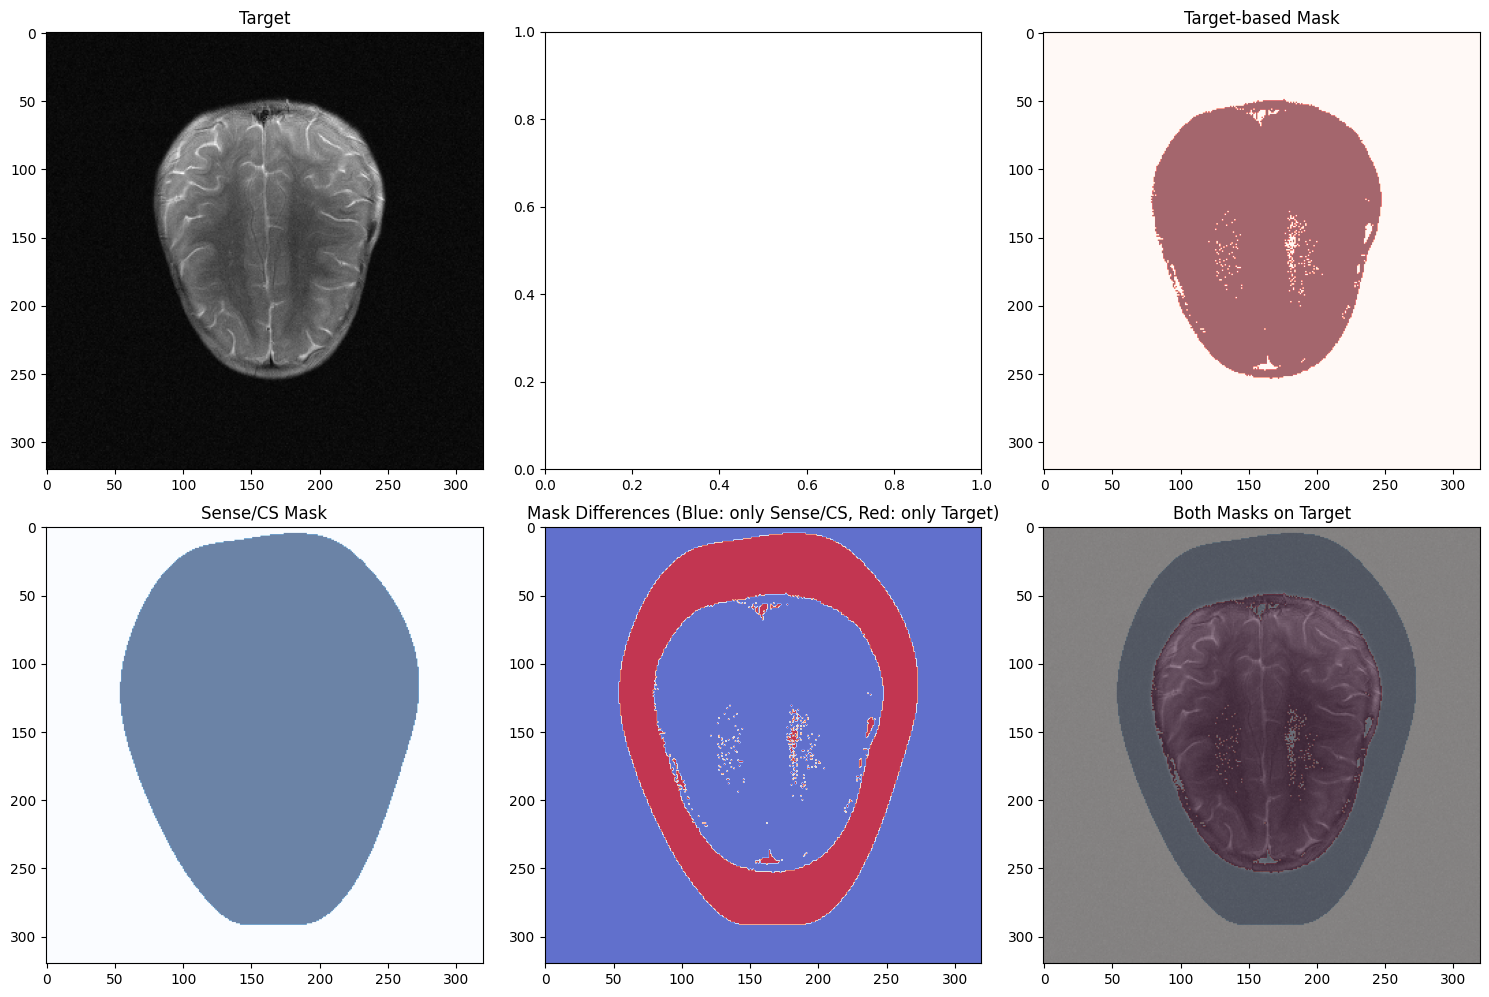

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from fastmri.data import transforms  # assuming you use this
from skimage.filters import threshold_otsu

# Load one example file 
tgt_file = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/file_brain_AXT2_202_2020356.h5")  # e.g. Path('/.../file.h5')
pred_file = Path("/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results/CSUNet/reconstructions/file_brain_AXT2_202_2020356.h5")

#tgt_file = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/file_brain_AXFLAIR_200_6002451.h5")
#tgt_file = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/file_brain_AXT1POST_203_6000722.h5")
#tgt_file = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/file_brain_AXT1_202_2020234.h5")
#tgt_file = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/file_brain_AXT1PRE_201_6002726.h5")



# Load arrays
with h5py.File(tgt_file, "r") as f:
    target = f["reconstruction_rss"][()]
# with h5py.File(pred_file, "r") as f:
#     recons = f["reconstruction"][()]

# Center crop if needed
target = transforms.center_crop(target, (target.shape[-1], target.shape[-1]))
# recons = transforms.center_crop(recons, (target.shape[-1], target.shape[-1]))

# ---------- Generate masks ----------
# 1. Target-based mask
thresh = threshold_otsu(target)
target_mask = (target > thresh).astype(int)


# 2. Sense + CS-based mask (your existing logic)
def sense_cs_mask(tgt_file, shape):
    base = Path("/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/")
    sense = np.array(h5py.File(base / "Sense" / tgt_file.name, "r")["reconstruction"])
    cs = np.array(h5py.File(base / "CS" / tgt_file.name, "r")["reconstruction"])
    sense = transforms.center_crop(sense, shape)
    cs = transforms.center_crop(cs, shape)
    mask_sense = (sense != 0).astype(int)
    mask_cs = (cs != 0).astype(int)
    return mask_sense & mask_cs

sense_cs = sense_cs_mask(tgt_file, (target.shape[-1], target.shape[-1]))

# ---------- Visualization ----------
# Pick a slice to visualize
slice_idx = target.shape[0] // 2

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

axs[0].imshow(target[slice_idx], cmap='gray')
axs[0].set_title("Target")

# axs[1].imshow(recons[slice_idx], cmap='gray')
# axs[1].set_title("Reconstruction")

axs[2].imshow(target_mask[slice_idx], cmap='Reds', alpha=0.6)
axs[2].set_title("Target-based Mask")

axs[3].imshow(sense_cs[slice_idx], cmap='Blues', alpha=0.6)
axs[3].set_title("Sense/CS Mask")

# Overlap mask differences
diff_mask = np.zeros_like(target[slice_idx])
diff_mask[(target_mask[slice_idx] == 1) & (sense_cs[slice_idx] == 0)] = 1  # extra in target
diff_mask[(target_mask[slice_idx] == 0) & (sense_cs[slice_idx] == 1)] = 2  # extra in sense/CS

axs[4].imshow(diff_mask, cmap='coolwarm', alpha=0.8)
axs[4].set_title("Mask Differences (Blue: only Sense/CS, Red: only Target)")

# Overlay mask on image
overlay = target[slice_idx].copy()
axs[5].imshow(overlay, cmap='gray')
axs[5].imshow(sense_cs[slice_idx], cmap='Blues', alpha=0.3)
axs[5].imshow(target_mask[slice_idx], cmap='Reds', alpha=0.3)
axs[5].set_title("Both Masks on Target")

plt.tight_layout()
plt.show()


Number of (effectively) zero pixels in CS mask: 54567


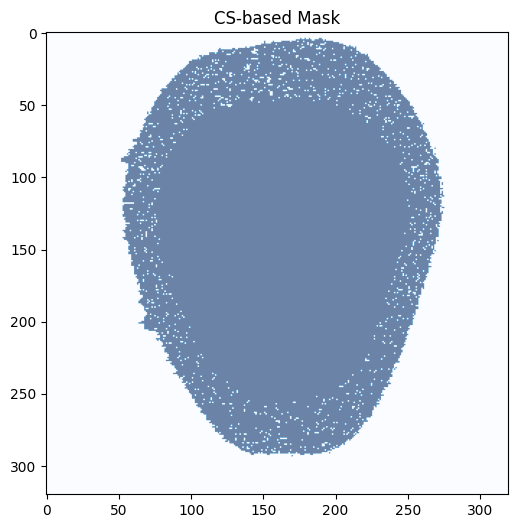

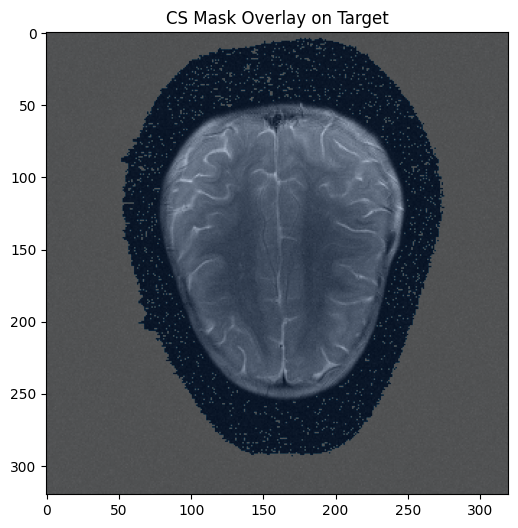

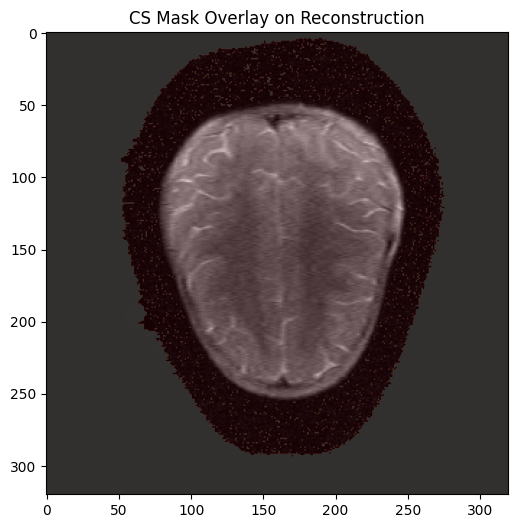

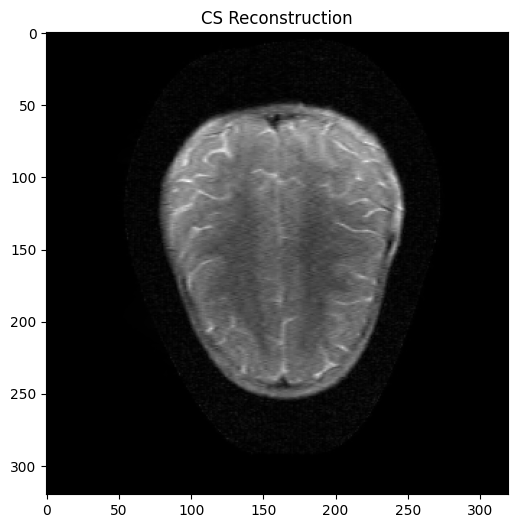

In [160]:
from fastmri.data import transforms as T

# what about a mask just based on CS?
def cs_mask(tgt_file, shape):
    '''
    For some files works well, for other no mask is generated cause values are close to zero 3
    but not exactly zero. => THRESHOLDING is needed!

    '''
    base = Path("/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/")
    cs = np.array(h5py.File(base / "CS" / tgt_file.name, "r")["reconstruction"])
    cs = transforms.center_crop(cs, shape)

    # # create figure of cs image
    # fig, ax = plt.subplots(figsize=(6, 6))
    # ax.imshow(cs[slice_idx], cmap='gray')
    # ax.set_title("CS Reconstruction")
    # plt.show()

    # the zero mask
    # mask_cs = (cs != 0).astype(int)
    # count = np.sum((cs[slice_idx]== 0).astype(int))
    # print(f"Number of zero pixels in CS mask: {count}")


     # Create mask using threshold
    threshold = 0.01 * np.max(cs)
    threshold = np.percentile(cs, 48)  # Use a percentile to set the threshold
    mask_cs = (np.abs(cs) > threshold).astype(int)
    #Count how many pixels are *below* threshold (almost zero)
    count = np.sum((np.abs(cs[slice_idx]) <= threshold).astype(int))
    print(f"Number of (effectively) zero pixels in CS mask: {count}")



    return mask_cs, cs
cs_mask, cs = cs_mask(tgt_file, (target.shape[-1], target.shape[-1]))
# Visualize CS mask
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cs_mask[slice_idx], cmap='Blues', alpha=0.6)
ax.set_title("CS-based Mask")
plt.show()
# Visualize CS mask on target
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(target[slice_idx], cmap='gray')
ax.imshow(cs_mask[slice_idx], cmap='Blues', alpha=0.3)
ax.set_title("CS Mask Overlay on Target")
plt.show()
# Visualize CS mask on reconstruction
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cs[slice_idx], cmap='gray')
ax.imshow(cs_mask[slice_idx], cmap='Reds', alpha=0.2)
ax.set_title("CS Mask Overlay on Reconstruction")
plt.show()
# visualize reconstruction alone
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cs[slice_idx], cmap='gray')
ax.set_title("CS Reconstruction")
plt.show()




In [ ]:
# ideally,to compare to last year, we just take the SENSE mask, cause the intersection of SENSE and CS is the same as the SENSE mask

## Check if SENSE mask = SENSE&CS mask (yes they do)

In [ ]:
import pathlib
import numpy as np
import h5py
import matplotlib.pyplot as plt
from fastmri.data import transforms
import csv

def generate_sense_mask(sense_path, shape):
    """Generates a binary mask from a SENSE reconstruction based on non-zero values."""
    with h5py.File(sense_path, 'r') as f:
        recon = np.array(f['reconstruction'])
    recon = transforms.center_crop(recon, shape)
    mask = (recon != 0).astype(int)
    return mask

def get_combined_mask(cs_path, sense_path, shape):
    """Returns the binary mask from the intersection of CS and SENSE reconstructions."""
    with h5py.File(sense_path, 'r') as f_sense:
        sense_recon = transforms.center_crop(np.array(f_sense['reconstruction']), shape)
    with h5py.File(cs_path, 'r') as f_cs:
        cs_recon = transforms.center_crop(np.array(f_cs['reconstruction']), shape)

    sense_mask = (sense_recon != 0).astype(int)
    cs_mask = (cs_recon != 0).astype(int)
    intersection_mask = sense_mask & cs_mask
    return intersection_mask


def batch_compare_masks(cs_dir, sense_dir, test_dir, csv_output_path):
    cs_dir = pathlib.Path(cs_dir)
    sense_dir = pathlib.Path(sense_dir)
    test_dir = pathlib.Path(test_dir)
    files = sorted(test_dir.glob("*.h5"))
    i=0
    
    # Prepare CSV file
    with open(csv_output_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Filename", "Differing Pixels", "Percent Difference"])

        for tgt_file in files:
            sense_path = sense_dir / tgt_file.name
            cs_path = cs_dir / tgt_file.name
            target_path = test_dir / tgt_file.name

            if not cs_path.exists():
                print(f"❌ Skipping: CS file not found for {tgt_file.name}")
                continue
            if not sense_path.exists():
                print(f"❌ Skipping: SENSE file not found for {tgt_file.name}")
                continue
            if not target_path.exists():
                print(f"❌ Skipping: Target file not found for {tgt_file.name}")
                continue

            #print(f"\nComparing mask for: {tgt_file.name}")
            # determine shape from target file
            with h5py.File(target_path, 'r') as f:
                shape = f['reconstruction_rss'].shape
                #print(f"Target shape: {shape}")
            sense_mask = generate_sense_mask(sense_path, (shape[-1], shape[-1]))
            combined_mask = get_combined_mask(cs_path, sense_path,  (shape[-1], shape[-1]))
            
            # compare masks
            diff = sense_mask != combined_mask
            num_diff = np.sum(diff)
            percent_diff = (num_diff / np.prod(sense_mask.shape)) * 100

            #print(f"🔍 {tgt_file.name}: {num_diff} pixels differ ({percent_diff:.4f}%)")
            writer.writerow([tgt_file.name, num_diff, f"{percent_diff:.4f}"])

            # print(sense_mask.shape)
            # # Optional visualization of one middle slice
            # slice_idx = shape[0] // 2
            # plt.figure(figsize=(12, 4))
            # plt.subplot(1, 3, 1)
            # plt.imshow(sense_mask[slice_idx], cmap='gray')
            # plt.title("SENSE Mask")

            # plt.subplot(1, 3, 2)
            # plt.imshow(combined_mask[slice_idx], cmap='gray')
            # plt.title("Combined Mask")

            # plt.subplot(1, 3, 3)
            # plt.imshow(diff[slice_idx], cmap='hot')
            # plt.title("Difference")

            # plt.tight_layout()
            # plt.show()
            # i+=1
            # if i > 5:
            #     break
        
sense_dir = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/Sense/'
cs_dir = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/CS/'
test_dir = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
csv_output_path = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/mask_comparison.csv'

batch_compare_masks(cs_dir, sense_dir, test_dir, csv_output_path)

In [7]:
sense_dir = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results_lastyear/Reconstructions/Sense/'

with h5py.File(pathlib.Path(sense_dir) / 'file_brain_AXT2_202_2020356.h5', 'r') as f:
    print(f.keys()) 

<KeysViewHDF5 ['reconstruction']>
